In [1]:
import torch
from transformers import AutoImageProcessor, ResNetForImageClassification
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Loading the pre-trained ResNet-50 model and processor
processor = AutoImageProcessor.from_pretrained("microsoft/resnet-50")
model = ResNetForImageClassification.from_pretrained("microsoft/resnet-50")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/266 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

In [3]:
# Writing a Function to add Gaussian noise
def adding_gaussian_noise(image, std=25):
    image_array = np.array(image)
    noise = np.random.normal(0, std, image_array.shape).astype('uint8')
    noisy_image = image_array + noise
    noisy_image = np.clip(noisy_image, 0, 255).astype('uint8')
    return Image.fromarray(noisy_image)

In [4]:
# writing a function to classify the image and return confidence score and prediction
def classifing_image(image):
    try:
        inputs = processor(images=image, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**inputs) # Running the model on the image
        logits = outputs.logits # Getting the raw model outputs
        probabilities = torch.nn.functional.softmax(logits, dim=-1) # Converting the outputs to probabilities
        top_probability, top_class = torch.max(probabilities, dim=-1) # Finding the top prediction
        predicted_label = model.config.id2label[top_class.item()] # Here, I am Getting the label for the top prediction
        return top_probability.item(), predicted_label
    except Exception as e:
        print(f"Error during classification: {e}")
        return None, None

In [5]:
# Loading and classifing the original image
main_image = Image.open('/content/Monu.jpeg')
original_confidence, original_prediction = classifing_image(main_image)

In [6]:
# adding in the levels for Different corruption levels (noise)
corruption_levels = np.arange(0, 100, 10)
confidence_scores = []
predictions = []

In [7]:
# Generating noisy images and classifing
for level in corruption_levels:
    noisy_image = adding_gaussian_noise(main_image, std=level)
    confidence, prediction = classifing_image(noisy_image)
    if confidence is not None:
        confidence_scores.append(confidence)
        predictions.append(prediction)
    else:
        confidence_scores.append(0)
        predictions.append("Classification failed")

# Convert confidence_scores to numpy array
confidence_scores = np.array(confidence_scores)

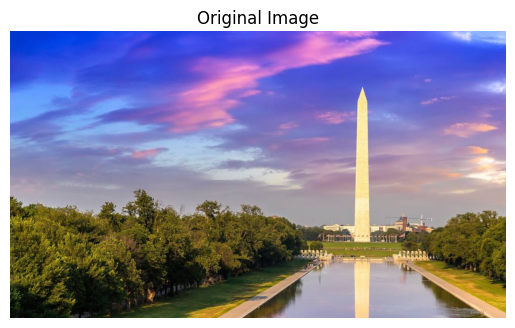

In [8]:
def show_image_label(image, label):
    plt.imshow(image)
    plt.axis('off')
    plt.title(label)
    plt.show()

show_image_label(main_image, 'Original Image')

(-0.5, 1079.5, 623.5, -0.5)

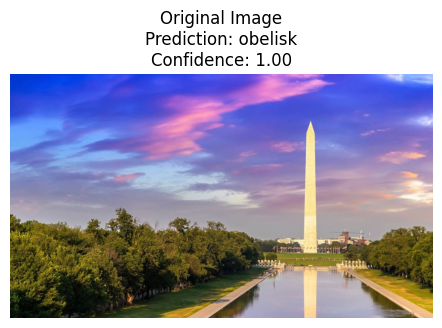

In [9]:
# Displaying the original and a noisy image with predictions
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(main_image)
plt.title(f'Original Image\nPrediction: {original_prediction}\nConfidence: {original_confidence:.2f}')
plt.axis('off')

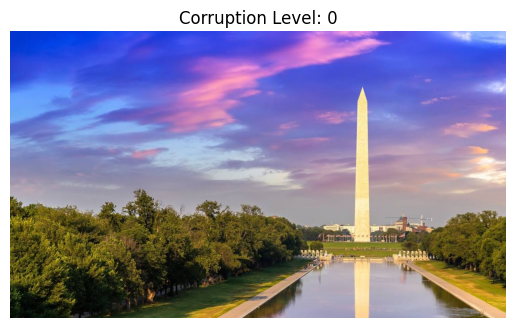

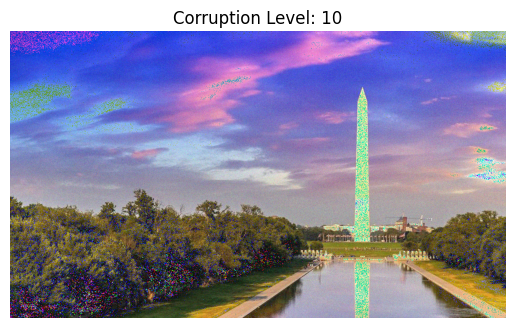

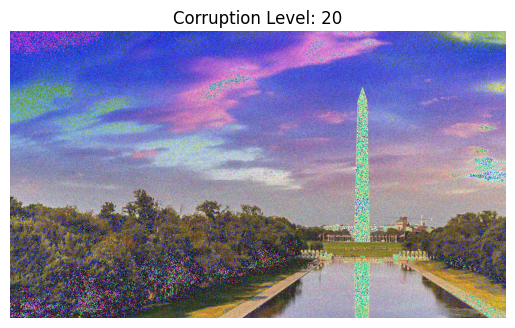

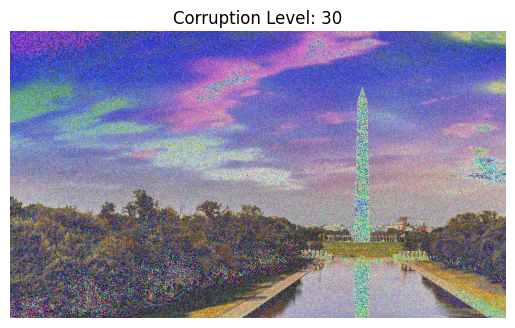

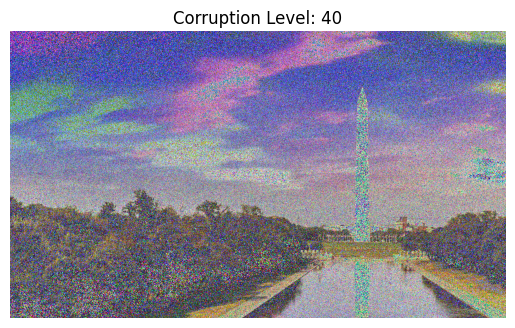

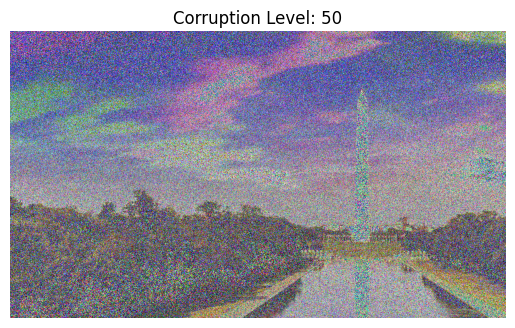

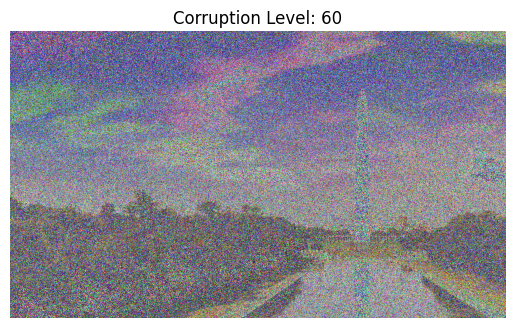

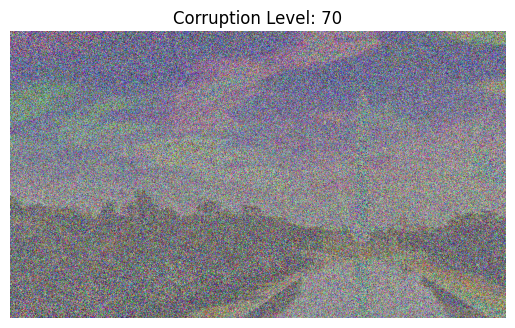

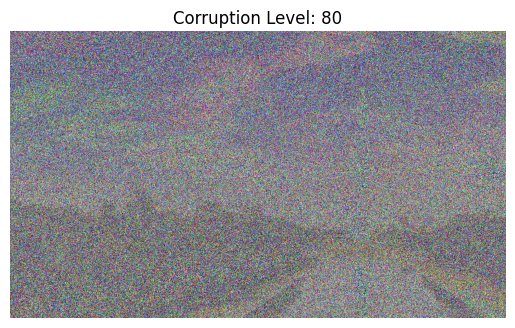

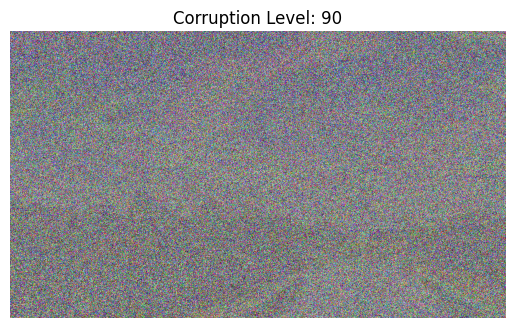

In [10]:
for level in range(0, 100, 10):  # Example of different noise levels
    noisy_image = adding_gaussian_noise(main_image, std=level)  # Add noise to the image
    confidence = classifing_image(noisy_image)  # Classify the noisy image
    confidence_scores = np.array(confidence_scores, dtype=float)  # Store confidence score

    # Display the noisy image
    plt.imshow(noisy_image)
    plt.title(f'Corruption Level: {level}')
    plt.axis('off')
    plt.show()

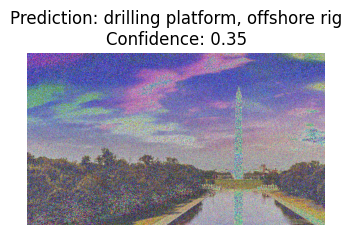

In [11]:
plt.subplot(1, 2, 2)
noisy_image = adding_gaussian_noise(main_image, std=40)
noisy_confidence, noisy_prediction = classifing_image(noisy_image)
plt.imshow(noisy_image)
plt.title(f'Prediction: {noisy_prediction}\nConfidence: {noisy_confidence:.2f}')
plt.axis('off')
plt.tight_layout()
plt.show()

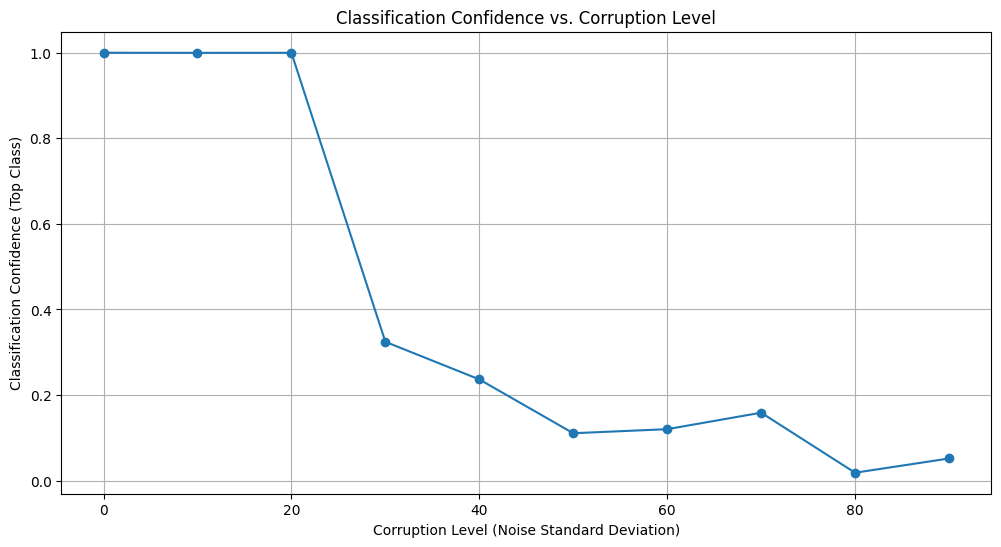

In [12]:
#plot of the the accuracy of the model before and adding in corruption.
plt.figure(figsize=(12, 6))
plt.plot(corruption_levels, confidence_scores, marker='o')
plt.title('Classification Confidence vs. Corruption Level')
plt.xlabel('Corruption Level (Noise Standard Deviation)')
plt.ylabel('Classification Confidence (Top Class)')
plt.grid(True)
plt.show()

In [13]:
#Printing out the predictions after each noise level.
print("Predictions at different noise levels:")
for level, prediction, confidence in zip(corruption_levels, predictions, confidence_scores):
    if confidence > 0:
        print(f"Noise level {level}: {prediction} (confidence: {confidence:.2f})")
    else:
        print(f"Noise level {level}: Classification failed")

Predictions at different noise levels:
Noise level 0: obelisk (confidence: 1.00)
Noise level 10: obelisk (confidence: 1.00)
Noise level 20: obelisk (confidence: 1.00)
Noise level 30: crane (confidence: 0.32)
Noise level 40: drilling platform, offshore rig (confidence: 0.24)
Noise level 50: drilling platform, offshore rig (confidence: 0.11)
Noise level 60: platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus (confidence: 0.12)
Noise level 70: platypus, duckbill, duckbilled platypus, duck-billed platypus, Ornithorhynchus anatinus (confidence: 0.16)
Noise level 80: hammerhead, hammerhead shark (confidence: 0.02)
Noise level 90: wool, woolen, woollen (confidence: 0.05)
